## Libraries

In [1]:
import tempfile
import math
import os
from subprocess import call
import matplotlib.pyplot as plt
from f90nml import *
from array import *
import numpy as np
import pandas as pd 
import seaborn as sns
from statistics import *
import shutil
import sys
import time
from matplotlib.ticker import FormatStrFormatter

#read in printFolder, makeDefNameList, newFolder, deleteFolder, readOutput from coreFunctions.py
from coreFunctions import *

#read in plotting functionality from plottingFunctions.py
from plottingFunctions import *

call("rm -rf tmp*",shell=True)

dfModel = []#will contain output from our model

In [2]:
def growthRates(dfModel,compare):
#     mpop = np.asarray(dfModel['pop'])
#     mdPdt = np.diff(mpop)
#     mgRate = mdPdt/100;
    mgBRate = np.asarray(dfModel['rBirth'])
    mgDRate = np.asarray(dfModel['rDeath'])
    mgRate = np.asarray(dfModel['rGrowth'])
#    print(mgRate)
    print("Model Min Growth Rate: "+ str(round(min(mgRate),4)))
    print("Model Max Growth Rate: "+ str(round(max(mgRate),4))+"\n")
    mtime = np.asarray(dfModel["time_yrs"])+1820
    plt.plot(mtime,mgBRate,label="Model Birth Growth")
    plt.plot(mtime,mgDRate,label="Model Death Growth")
    plt.plot(mtime,mgRate,label="Model Relative Growth")
    

    dfPopCo2 = pd.read_csv('world_stats.csv');#data from Frank, Adam, and Woodruff Sullivan.
    time = np.asarray(dfPopCo2['time'])
    pop = np.asarray(dfPopCo2['population'])
    pop = pop/10**3#billion --> million
    dP = np.diff(pop)
    dt = np.diff(time)
    dPdt=dP/dt#number of people per year (in millions)
    gRate = dPdt/100;

    print("Real Min Growth Rate: "+ str(round(min(gRate),4)))
    print("Real Max Growth Rate: "+ str(round(max(gRate),4)))
    
    if compare: plt.plot(time[1:],gRate,label="True Values")
    
    dfPopPred = pd.read_csv('worldPopPredictions.csv');#data from Frank, Adam, and Woodruff Sullivan.
    dfPopPred.columns = ["time","pop"]
    time2 = np.asarray(dfPopPred['time']).astype(int)
    pop2 = np.asarray(dfPopPred['pop'])
    pop2 = pop2/10**3#billion --> millio
    dP2 = np.diff(pop2)
    dt2 = np.diff(time2)
    dPdt2=dP2/dt2#number of people per year (in millions)
    gRate2 = dPdt2/100;

    print("Real Min Growth Rate: "+ str(round(min(gRate2),4)))
    print("Real Max Growth Rate: "+ str(round(max(gRate2),4)))
    
    if compare: plt.plot(time2[1:],gRate2,label="True Values",c='black')
    
    plt.legend()

In [3]:
def runModel(nameList, coupled, runTime, plot, save, analyze):
    for j in [284]:#pco2 loops
        newPco2=int(j)#change pco2 (ppm)
        #    newA = .9#change distance (AU)
        #    dA=.01
        #    minA, maxA, fullMaxPop, fullMaxPopA = habitableZone(nameList,newPco2,newA,runTime,dA)
        #    print("The Habitable Zone if pCO2="+str(round(newPco2)) + "ppm is:")
        #    print("Minimum: "+str(minA) + " AU")
        #    print("Maximum: "+str(maxA)+" AU")
        #    print("Max Pop: " + str(fullMaxPop)+ " billion" + ", at Distance: " + str(round(fullMaxPopA,3))+"\n") 

     #   for i in np.linspace(0.93,1.03,5):#population loops
        for i in [1]:#distance loops
            #calculate inputs
            newA = round(i,3) #change distance (AU)
            nameList['ebm']['coupled']=coupled
            nameList['ebm']['pco20']=newPco2/10**6#convert pco2 to bars
            nameList['ebm']['relsolcon']=newA**-2 #inverse square law for solar flux
            nameList['ebm']['runTime'] = runTime#change runtime
            #run program
            dfModel, finalavgtemp, eqTime, eqTemp, equilibrium = runProgram("driver",nameList,True)#False=no output
            #plot the results
            if coupled and equilibrium:
                inputRunTime = runTime #how long I originally specified
                outputRunTime = math.ceil( dfModel['time_yrs'].iloc[-1] )#how long it actually ran
                if ((inputRunTime - outputRunTime) <= 3) and analyze:
                    popStats = analyzeRun(dfModel,nameList, True)#if True, then Print Dictionary Values
                    fullMaxPop=popStats["maxPop"]
                    popStats['maxPopPlot']=fullMaxPop+(3/100)*fullMaxPop#maximum population range
                else:
                    print("Program Stopped at: " + str((outputRunTime/inputRunTime)*100) + " %" + "\n")
                inputs=[newA,newPco2,runTime]
                if equilibrium and plot: plotModelOutput(dfModel,inputs,eqTime,eqTemp,popStats,save,saveName)#plot the output of our model, colored by pco2 
                if save: saveName+=1
                #partitition dataframe into numpy arrays
                popArr=np.asarray(dfModel["pop"])
                pop=np.ndarray.tolist(popArr/1000)
                pco2=dfModel["pco2_ppm"].tolist()
                time=dfModel["time_yrs"].tolist()
                temp=dfModel["temp"].tolist()
                runArr= [pop,temp,pco2,time]#make list of lists
                fullArrTr = zip(pop,temp,pco2,time)#make list of lists
                fullArr.append(runArr)#add the data from the run into the 2dList
    return dfModel
        #end = time.time()
    #print( "Elapsed Time: " + str(end-start))

## Enter Custom Inputs, then Run the Model

Equilibrium Reached at Temp=287.09. At time=22.0
Final Temp(K): 287.6229467
Final Temp(F): 58.05

Program Stopped at: 100.0 %

Model Min Growth Rate: -0.0371
Model Max Growth Rate: 0.008

Real Min Growth Rate: 0.0431
Real Max Growth Rate: 0.8295
Real Min Growth Rate: -0.2104
Real Max Growth Rate: 0.929


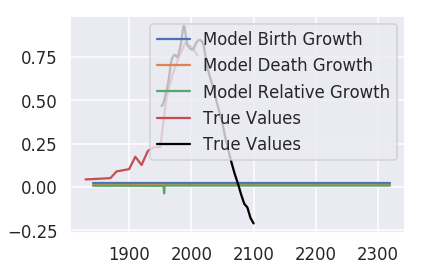

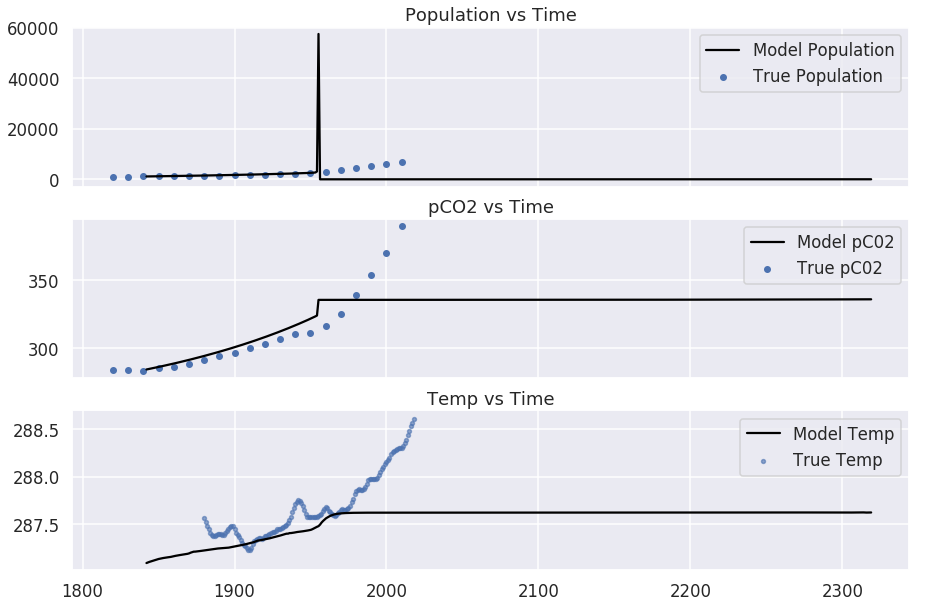

In [11]:
nameList = makeDefNamelist() #make namelist
#'rBirthNaked': 0.027855, 'rBirthTech': 0.0, 'rBirthMax': 0.83, 'rDeath': 0.0142857,
nameList['ebm']['lverbose']=True #controls terminal output, used for debugging
nameList['ebm']['rco2']=2.00e-4;
# nameList['ebm']['En']=.0297;
nameList['ebm']['rBirthMax']=.85;
nameList['ebm']['Nmax']=10200;
nameList['ebm']['rBirth0']=0.02;
nameList['ebm']['rDeath0']=0.012;
nameList['ebm']['pBirth'] = 0
nameList['ebm']['pDeath'] = 0
nameList['ebm']['En0']=1.00
nameList['ebm']['rTech']=5*10**-5
#nameList['ebm']['fragility']=10**-2
#nameList['ebm']['En']=.0014
nameList['ebm']['fragility']=.001
life=False;
fullArr=[]
fullArrTr = []

#start = time.time()
#specify inputs
runTime=500#change runtime(years)
plot=False;#controls plotting
coupled=True
save=False;#save the file
saveName=1;#name of file
fullMaxPop=0
newA=1
newPco2 = 284
analyze = False #whether or not to analyze the population parts of model
dfModel = runModel(nameList, coupled, runTime, plot, save, analyze)
call("echo End of Python Notebook Reached", shell=True);
growthRates(dfModel,True) #true to compare growth rates
dfTemp = pd.read_csv('anomaly.csv');#data from NASA GISS: https://data.giss.nasa.gov/gistemp/graphs_v4/
dfPopCo2 = pd.read_csv('world_stats.csv');#data from Frank, Adam, and Woodruff Sullivan.
compareModelOutput(dfModel,dfTemp,dfPopCo2)#compare the models output to true data

#### Misc

In [5]:
sns.set_context("talk")
sns.set_style("darkgrid")
pop = []
pco2 = []
temp = []
time = []
#for row in fullArr: #0=pop, 1=temp, 2=pCO2, 3=time
#    plt.scatter(np.log10(row[1]),row[0],c=row[2],cmap='jet',s=np.asarray(row[3])/30);
#     plt.xlabel("Population ($x10^{9}$)");
#     plt.ylabel("Temp (K)");
#     pop.append(row[0])
#     temp.append(row[1])
#     pco2.append(row[2])
#     time.append(row[3])
# plt.colorbar(label="pCO2 (ppm)")
#plt.show();

## Model Analysis

In [6]:
#dfTemp = pd.read_csv('anomaly.csv');#data from NASA GISS: https://data.giss.nasa.gov/gistemp/graphs_v4/
#dfPopCo2 = pd.read_csv('world_stats.csv');#data from Frank, Adam, and Woodruff Sullivan.
#plotModelInput(nameList)#plot the temperature dependence on the growth rate
#plotTruePopCo2(dfPopCo2) #plot true population values vs pco2
#compareModelOutput(dfModel,dfTemp,dfPopCo2)#compare the models output to true data